## Binary Classification: Gender classifier data
https://www.crowdflower.com/data-for-everyone/

** Dataset Information: **

- 20,000 images from Twitter profile

** Attribute Information: **

- color images

** Objective of this project **

- judge whether the user was a male or a female

## Data

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

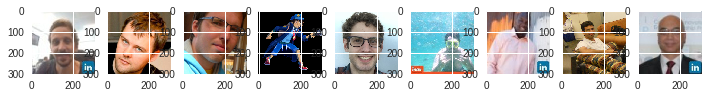

In [14]:
filepath = 'drive/app/gender/'
# plot the first 9 males
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/male/'+os.listdir(filepath+'train_set/male/')[i]))

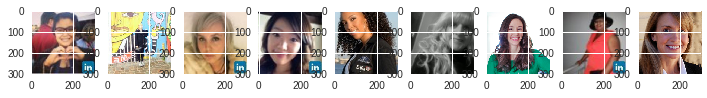

In [17]:
# plot the first 9 female
plt.figure(figsize=(12,6))
for i in range(0, 9):
    plt.subplot(190 + (i+1))
    plt.imshow(image.load_img(filepath+'train_set/female/'+os.listdir(filepath+'train_set/female/')[i]))

## Data preprocessing

In [15]:
# Generate minibatches of image data with real-time data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# read image data
train_set = train_datagen.flow_from_directory(filepath+'train_set',
                                              target_size = (64, 64),
                                              batch_size = 32,
                                              class_mode = 'binary')

test_set = test_datagen.flow_from_directory(filepath+'test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 11663 images belonging to 2 classes.
Found 2920 images belonging to 2 classes.


In [27]:
train_set.class_indices

{'female': 0, 'male': 1}

In [28]:
train_set.data_format

'channels_last'

In [29]:
train_set.image_shape

(64, 64, 3)

## CNN

### Train the Network

In [16]:
# import libraries
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint

seed = 123
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
# compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

In [17]:
# callbacks
filepath_model = filepath+'weights_best_model.hdf5'
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
checkpoint = ModelCheckpoint(filepath_model, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint, early_stop]

# train the model
model.fit_generator(train_set, 
                    steps_per_epoch = 11663//32, 
                    epochs = 100, 
                    validation_data = test_set, 
                    validation_steps = 2920//32,
                    callbacks = callbacks_list) 

Epoch 1/100
364/364 [==============================] - 465s 1s/step - loss: 0.6129 - acc: 0.6457 - val_loss: 0.5341 - val_acc: 0.7191

Epoch 00001: val_loss improved from inf to 0.53409, saving model to drive/app/gender/weights_best_model.hdf5
Epoch 2/100
196/364 [===============>..............] - ETA: 37s - loss: 0.5200 - acc: 0.7274364/364 [==============================] - 98s 270ms/step - loss: 0.5124 - acc: 0.7361 - val_loss: 0.4520 - val_acc: 0.7840

Epoch 00002: val_loss improved from 0.53409 to 0.45201, saving model to drive/app/gender/weights_best_model.hdf5
Epoch 3/100
261/364 [====================>.........] - ETA: 23s - loss: 0.4679 - acc: 0.7670364/364 [==============================] - 99s 271ms/step - loss: 0.4682 - acc: 0.7682 - val_loss: 0.4199 - val_acc: 0.7960

Epoch 00003: val_loss improved from 0.45201 to 0.41992, saving model to drive/app/gender/weights_best_model.hdf5
Epoch 4/100
275/364 [=====================>........] - ETA: 20s - loss: 0.4500 - acc: 0.7789364/

#### Evaluate the Network

In [18]:
from itertools import islice
X_test = []
y_test = []
for ts in islice(test_set, round(2920/32)):
    X_test.append(ts[0])
    y_test.append(ts[1])

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
X_test.shape,y_test.shape

((2912, 64, 64, 3), (2912,))

2912/2912 [==============================] - 1s 190us/step
Accuracy:	83.9%
roc auc:	0.840


             precision    recall  f1-score   support

        0.0       0.87      0.80      0.84      1490
        1.0       0.81      0.88      0.84      1422

avg / total       0.84      0.84      0.84      2912



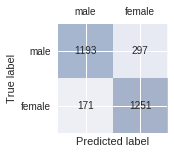

In [19]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
# predict class with test set
model.load_weights(filepath_model)
y_pred_test =  model.predict_classes(X_test, batch_size=32, verbose=1).ravel()
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))
print('roc auc:\t{:0.3f}'.format(roc_auc_score(y_test,y_pred_test)))

#classification report
print('\n')
print(classification_report(y_test, y_pred_test))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xticks((0,1),('male', 'female'))
plt.yticks((0,1),('male', 'female'))    
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

#### Predict new images

In [0]:
def male_or_female(filename):    
    test_image = image.load_img(filepath+'prediction/'+filename, target_size = (64, 64))
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        return 'male'
    else:
        return 'female'

'female'

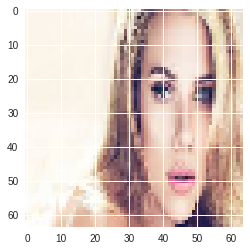

In [32]:
male_or_female('male_or_female1.jpg')

'male'

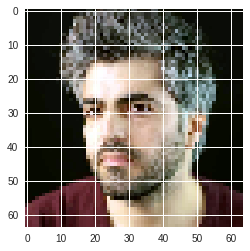

In [33]:
male_or_female('male_or_female2.jpg')

'male'

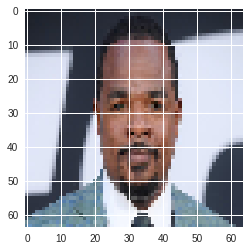

In [34]:
male_or_female('male_or_female3.jpg')

'female'

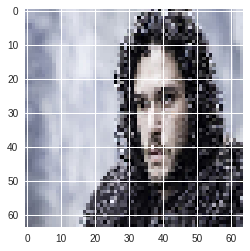

In [35]:
male_or_female('male_or_female4.jpg')